# Scores and result plots for artificial data

Note that it is assumed that the data has shape (shape 0, shape 1, 1), so this can only be used with data from the VGG inspired net or other data with this shape. The data with three color channels can be analyzed in the notebook for the VGG experiment. 

In [1]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from copy import deepcopy

import time, datetime 

import h5py
import pickle as pkl

from sklearn.preprocessing import minmax_scale
from sklearn.metrics import auc, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics._ranking import _binary_clf_curve

import seaborn as sns
import ptitprince as pt

from matplotlib import gridspec

In [2]:
save_fig = True

In [3]:
sns.set_style('dark')
plt.rcParams["font.size"] = "13"

In [4]:
# for the MRI data, the ground truth is saved in a weird way and needs to be flattened, so for MRI set to true 
mri_img = True
brain_pixels = True
# for Gaussian lesions the ground truth needs to be thresholded differently
gaussian = False

## Get and prepare data

In [5]:
ground_truth_type = 'lesion_based'

In [6]:
result_dir = '/ritter/share/projects/Methods/Budding_interpret_ground_truth/results/perlin_vs_mri/mri'
data_dir = '/ritter/share/projects/Methods/Budding_interpret_ground_truth/data/hamming_lateral_vs_none'
name = f'mri_hamming_vs_none_{ground_truth_type}'

In [7]:
with open(os.path.join(result_dir, 'heatmaps/simple_model_best_fold.pkl'), 'rb') as f: 
    heatmaps = pkl.load(f)

In [8]:
holdout_h5 = h5py.File(os.path.join(data_dir, 'holdout_data.h5'), 'r')
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_holdout = np.array(X_holdout)
y_holdout = np.array(y_holdout)

In [9]:
X_holdout = X_holdout[:12000]
y_holdout = y_holdout[:12000]
print(len(X_holdout), len(y_holdout))

12000 12000


In [10]:
if ground_truth_type == 'lesion_based': 
    with open(os.path.join(data_dir, 'ground_truth_maps_holdout.pkl'), 'rb') as f: 
        ground_truth = pkl.load(f)
        
elif ground_truth_type == 'whole_dataset': 
    num = len(heatmaps['gradient']) 
    mask = np.ones((128, 128))
    mask[64:, :] = 0
    ground_truth_list = []
    for i in range(num): 
        ground_truth_list += [mask]
    ground_truth = np.array(ground_truth_list)
    
elif ground_truth_type == 'quadrants': 
    num = len(heatmaps['gradient'])
    mask_1 = np.zeros((128, 128))
    mask_1[:64, :64] = 1
    mask_2 = np.zeros((128, 128))
    mask_2[:64, 64:] = 1

    ground_truth_list = []
    for i in range(num): 
        if y_holdout[i] == 0: 
            ground_truth_list += [mask_1]
        else: 
            ground_truth_list += [mask_2]
    ground_truth = np.array(ground_truth_list)
    
elif ground_truth_type == 'within_lesions': 
    with open(os.path.join(data_dir, 'ground_truth_maps_holdout.pkl'), 'rb') as f: 
        ground_truth = pkl.load(f)

    with open(os.path.join(data_dir, 'ground_truth_maps_full_holdout.pkl'), 'rb') as f: 
        ground_truth_full = pkl.load(f)

In [11]:
len(ground_truth)

201

In [12]:
with open(os.path.join(result_dir, 'heatmaps/prediction_scores.pkl'), 'rb') as f: 
    prediction_scores = pkl.load(f)

In [13]:
if mri_img: 
    ground_truths = []
    for idx in range(200): 
        slice_idx = idx % 135
        part_idx = int(idx/135)
        ground_truths.append(ground_truth[part_idx][slice_idx][2])
    print(len(ground_truths))
    
    ground_truth = ground_truths

200


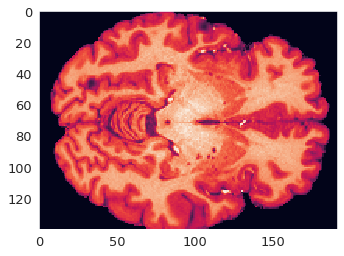

In [14]:
plt.imshow(X_holdout[53])

In [15]:
# plt.imshow(ground_truth[53])

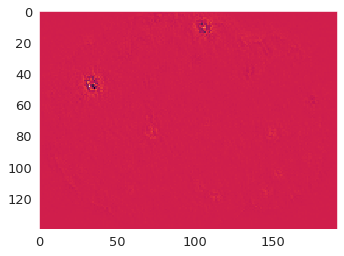

In [16]:
plt.imshow(heatmaps['gradient'][53].reshape(heatmaps['gradient'][50].shape[1], heatmaps['gradient'][50].shape[2]))

In [17]:
labels = y_holdout[:200]
list_idx_pos = [i for i in range(200) if labels[i] == 1]
all_idx = np.arange(len(labels))

In [18]:
def explanation_to_heatmap(e):
    tmp = (e/np.max(np.abs(e))) * 127.5 + 127.5
    colormap = plt.cm.get_cmap("seismic")
    tmp = colormap(tmp.flatten().astype(np.int64))[: , :3]
    tmp = tmp.reshape((e.shape[0], e.shape[1], 3)) 
    return tmp

def explanation_to_projection(e):
    # To range [0, 1]
    return (np.abs(e)/np.max(np.abs(e)))

def explanation_to_graymap(e):
    # Reduce color axis
    # To range [0, 255]
    tmp = ( e / np.max(np.abs(e))) * 255

    # Create and apply red - blue heatmap
    colormap = plt.cm.get_cmap("gray")

    tmp = colormap(tmp.flatten().astype(np.int64 ))[: , :3]
    tmp = tmp.reshape((e.shape[0], e.shape[1], 3))
    return tmp

In [19]:
methods = ['gradient', 'deep_taylor', 'lrp.z', 'lrp.alpha_beta', 'deconvnet', 'guided_backprop', 'pattern.net', 'pattern.attribution']
methods_title_list = ['Gradient', 'DTD', 'LRP-z', 'LRP-alpha/beta', 'DeConvNet', 'Guided Backprop', 'PatternNet', 'PatternAttribution']

In [20]:
def prepare_heatmaps_ground_truth(heatmap, ground_truth, heatmap_shape = None, normalization = None, ground_truth_type = None, mri_img = mri_img):
    heatmap = np.abs(heatmap)
    heatmap = np.nan_to_num(heatmap)
    heatmap = heatmap.flatten()
    
    ground_truth = minmax_scale(ground_truth.flatten())
    unique_vals = np.unique(ground_truth)
    
    mask = ground_truth.flatten()
    if gaussian: 
        perc = np.percentile(ground_truth, 99)
        mask = ground_truth > perc 
        mask = mask.flatten() * 1
    else: 
        mask[mask > 0] = 1

    return heatmap, mask 

In [21]:
def prepare_data_within_lesions(ground_truth, ground_truth_full, heatmaps, num = 200, methods = methods):
    ground_truth_list = []
    heatmap_dict = {}
    for method in methods: 
        heatmap_list = []
        for i in range(num):
            if ground_truth_full is not None: 
                mask_ground_truth = ground_truth_full[i] > 0
                lesion_pixels = ground_truth_full[i][mask_ground_truth]
            else: 
                mask_ground_truth = ground_truth[i] > 0
                lesion_pixels = ground_truth[i][mask_ground_truth]
                                               
            ground_truth_lesions = ground_truth[i][mask_ground_truth]
            ground_truth_list += [ground_truth_lesions]

            heatmap = heatmaps[method][i].reshape((heatmaps[method][i].shape[1], heatmaps[method][i].shape[2]))
            heatmap_lesions = heatmap[mask_ground_truth]
            heatmap_list += [heatmap_lesions]
        heatmap_dict[method] = heatmap_list
        
    return ground_truth_list, heatmap_dict

def prepare_ground_truth_mri(X_holdout, heatmaps, ground_truth, num = 200, methods = methods):
    ground_truth_list = []
    heatmap_dict = {}
    for method in methods: 
        heatmap_list = []
        for i in range(num):
            mask_ground_truth = X_holdout[i] > 0
            ground_truth_lesions = ground_truth[i][mask_ground_truth]
            ground_truth_list += [ground_truth_lesions]

            heatmap = heatmaps[method][i].reshape((heatmaps[method][i].shape[1], heatmaps[method][i].shape[2]))
            heatmap_lesions = heatmap[mask_ground_truth]
            heatmap_list += [heatmap_lesions]
        heatmap_dict[method] = heatmap_list
        
    return ground_truth_list, heatmap_dict

## Overview plot heatmaps high vs low score

In [24]:
softmax_scores = [prediction_scores['gradient'][i][0] for i in range(len(prediction_scores['gradient']))]
softmax_output = np.array([i.max() for i in softmax_scores])
pred_labels = np.array([prediction_scores['gradient'][i][2] for i in range(len(prediction_scores['gradient']))])

idx_class_0 = np.arange(200)[(labels == 0) & (pred_labels == 0)]
idx_class_1 = np.arange(200)[(labels == 1) & (pred_labels == 1)]

softmax_output_class_0 = softmax_output[(labels == 0) & (pred_labels == 0)]
softmax_output_class_1 = softmax_output[(labels == 1) & (pred_labels == 1)]

idx_min_0 = idx_class_0[softmax_output_class_0.argmin()]
idx_max_0 = idx_class_0[softmax_output_class_0.argmax()]

idx_min_1 = idx_class_1[softmax_output_class_1.argmin()]
idx_max_1 = idx_class_1[softmax_output_class_1.argmax()]

print(idx_min_0, idx_max_0, idx_min_1, idx_max_1)

indices = [idx_max_0, idx_min_0, idx_max_1, idx_min_1]

128 193 188 61


In [23]:
# def plot_overview_heatmaps(X_holdout, y_holdout, heatmaps, ground_truth, labels, softmax_output = softmax_output, pred_labels = pred_labels, indices = indices, methods = methods, figsize = (25, 10), save_fig = save_fig, title = 'overview_heatmaps_good_and_bad', label_idx = False):
#     fig = plt.figure(figsize = figsize)
#     k = 0
#     for i, idx in enumerate(indices): 
#         ground_truth_map = ground_truth[idx]
#         sample = X_holdout[idx]
#         label = y_holdout[idx]

#         for j in range(len(methods ) + 2): 
#             plt.subplot(len(indices), 2 + len(methods), k + j + 1)

#             ax = plt.gca()
#             ax.axes.xaxis.set_ticks([])
#             ax.axes.yaxis.set_ticks([])

#             if j % (2 + len(methods)) == 0: 
#                 cmap = 'gist_gray'
#                 plt.imshow(sample, cmap)
#                 plt.ylabel(f'Class {label},\nsm {softmax_output[idx]:.2f}')
#                 plt.title(f'Sample {idx}')

#             elif j % (2 + len(methods)) == 1: 
#                 cmap = 'gist_gray'
#                 plt.imshow(ground_truth_map, cmap)
#                 if k == 0: 
#                     plt.title('Ground truth')
#             else: 
#                 method = methods[j - 2]
#                 heatmap = heatmaps[method][idx].reshape(heatmaps[method][idx].shape[1], heatmaps[method][idx].shape[2])

#                 if method == 'pattern.net' or method == 'deconvnet' or method == 'guided_backprop': 
#                     heatmap = explanation_to_projection(heatmap)
#                     cmap = 'binary'
                
#                 elif method == 'gradient': 
#                     heatmap = explanation_to_heatmap(np.abs(heatmap))

#                 else: 
#                     heatmap = explanation_to_heatmap(heatmap)
#                 plt.imshow(heatmap, cmap)

#                 if k == 0: 
#                     plt.title(f'{method}')

#         k += 2 + len(methods)
#     fig.tight_layout()

#     if save_fig is True: 
#         output_path = f'figures/{title}.pdf'
#         fig.savefig(os.path.join(result_dir, output_path), orientation='landscape', dpi=300)


In [24]:
def plot_overview_heatmaps(X_holdout, y_holdout, heatmaps, ground_truth, labels, softmax_output = softmax_output, pred_labels = pred_labels, indices = indices, methods = methods, figsize = (25, 10), save_fig = save_fig, title = 'overview_heatmaps_good_and_bad', label_idx = False):
    k = 0
    
    nrow = len(indices)
    ncol = len(methods) + 2
    
    if X_holdout[0].shape[0] == X_holdout[0].shape[1]: 
        fig = plt.figure(figsize = (2 * (ncol + 1), 2 * (nrow + 1)))
    else: 
        fig = plt.figure(figsize = (2 * (ncol + 1), 2 * (nrow) - 1))

    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.0, hspace=0.0, 
             top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
             left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 
    
    for i, idx in enumerate(indices): 
        ground_truth_map = ground_truth[idx]
        sample = X_holdout[idx]
        label = int(y_holdout[idx])

        for j in range(len(methods) + 2): 
#             plt.subplot(len(indices), 2 + len(methods), k + j + 1)
            ax = plt.subplot(gs[i, j])
            ax.axes.xaxis.set_ticks([])
            ax.axes.yaxis.set_ticks([])

            if j % (2 + len(methods)) == 0: 
                cmap = 'gist_gray'
                ax.imshow(sample, cmap)
                ax.set_ylabel(f'Class {label + 1} \nsm {softmax_output[idx]:.2f}', rotation = 0, labelpad = 35, ha = 'center', fontsize = 14)
#                 h.set_rotation(0)
                if k == 0: 
                    ax.set_title('Sample')
#                 ax.set_title(f'Sample {idx}')

            elif j % (2 + len(methods)) == 1: 
                cmap = 'gist_gray'
                ax.imshow(ground_truth_map, cmap)
                if k == 0: 
                    ax.set_title('Ground truth')
            else: 
                method = methods[j - 2]
                heatmap = heatmaps[method][idx].reshape(heatmaps[method][idx].shape[1], heatmaps[method][idx].shape[2])

                if method == 'pattern.net' or method == 'deconvnet' or method == 'guided_backprop': 
                    heatmap = explanation_to_projection(heatmap)
                    cmap = 'binary'
                
                elif method == 'gradient': 
                    heatmap = explanation_to_heatmap(np.abs(heatmap))

                else: 
                    heatmap = explanation_to_heatmap(heatmap)
                ax.imshow(heatmap, cmap)

                if k == 0: 
                    plt.title(f'{method}')

        k += 2 + len(methods)
#     fig.tight_layout()

    if save_fig is True: 
        output_path = f'figures/{title}.pdf'
        fig.savefig(os.path.join(result_dir, output_path), orientation='landscape', dpi=300, bbox_inches = 'tight')


In [23]:
# plot_overview_heatmaps(X_holdout, y_holdout, heatmaps, ground_truth, labels, indices = indices, save_fig = save_fig, title = f'examples_heatmaps_{name}')

## Overview plot all heatmaps, eight random examples 

In [25]:
labels = y_holdout[:200]
correct_labels = np.where(labels == pred_labels)[0]

In [26]:
list_idx = np.random.choice(correct_labels, 8, replace = False)
print(list_idx)

[ 36  23  42  66  59  69  70 176]


In [28]:
# plot_overview_heatmaps(X_holdout, y_holdout, heatmaps, ground_truth, labels, figsize = (35, 30), indices = list_idx, save_fig = save_fig, title = f'random_heatmaps_{name}')

## Define functions for all scores

In [29]:
def precision_curves(y_true, probas_pred, *, pos_label=None,
                     sample_weight=None):
    """
    Minor adaption of corresponding scikit-learn function
    """
    fps, tps, thresholds = _binary_clf_curve(y_true, probas_pred,
                                             pos_label=pos_label,
                                             sample_weight=sample_weight)

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / tps[-1]
    specificity = 1 - fps / fps[-1]

    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], np.r_[specificity[sl], 1], thresholds

In [30]:
def average_precision(heatmap, ground_truth): 
    ap = average_precision_score(ground_truth, heatmap)
    return ap 

In [31]:
def precision_at_fixed_specificity(heatmap, ground_truth, threshold = 0.99): 
    precision, recall, specificity, thresholds = precision_curves(ground_truth, heatmap)
    if np.all(heatmap == heatmap[0]): 
        score = 0
    else: 
        score = precision[specificity > threshold][0]

    return score

In [32]:
def calc_auc_score(heatmap, ground_truth):
    auc = roc_auc_score(ground_truth, heatmap)
    return auc

In [33]:
def area_under_precision_recall_curve(heatmap, ground_truth):
    precision, recall, thresholds = precision_recall_curve(ground_truth, heatmap)
    auprc = auc(recall, precision)
    return auprc  

## Calculate dataframe with all scores

In [34]:
scores_dict = {'ROC-AUC' : calc_auc_score, 'mAP' : average_precision, 'prec at spec > 0.99' : precision_at_fixed_specificity}

In [35]:
def calculate_all_scores(methods, heatmaps, ground_truth_list, list_idx = list_idx_pos, scores_dict = scores_dict, ground_truth_type = None): 
    result_dict = dict()
    
    list_methods = list()
    indices = list()
    list_scores = list()
    list_vals = list()
    
    if ground_truth_type == 'within_lesions':
        ground_truth_list, heatmaps = prepare_data_within_lesions(ground_truth_list, ground_truth_full, heatmaps)
    
    if brain_pixels: 
        print('Correcting images for brain size')
        ground_truth_list, heatmaps =  prepare_ground_truth_mri(X_holdout, heatmaps, ground_truth_list)
    
    for i, method in enumerate(methods):
        method_name = methods_title_list[i]
        for idx in list_idx: 
            if ground_truth_type == 'within_lesions' or brain_pixels: 
                heatmap = heatmaps[method][idx]
            else: 
                heatmap = heatmaps[method][idx].reshape(heatmaps[method][idx].shape[1], heatmaps[method][idx].shape[2])
            ground_truth = ground_truth_list[idx]
            heatmap, ground_truth = prepare_heatmaps_ground_truth(heatmap, ground_truth)
            
            for key in scores_dict.keys(): 
                val = scores_dict[key](heatmap, ground_truth)
                
                list_vals += [val]
                list_methods += [method_name]
                list_scores += [key]
                indices += [idx]

    result_dict = {'method' : list_methods, 'idx' : indices, 'score' : list_scores, 'vals' : list_vals}

    df_scores = pd.DataFrame(result_dict, columns = ['method', 'idx', 'score', 'vals'])
    
    return df_scores

In [36]:
df_scores = calculate_all_scores(methods, heatmaps, ground_truth_list = ground_truth, list_idx = list_idx_pos, ground_truth_type = ground_truth_type)

Correcting images for brain size


In [37]:
df_scores.tail()

,method,idx,score,vals
2491,PatternAttribution,197,mAP,0.030895
2492,PatternAttribution,197,prec at spec > 0.99,0.080189
2493,PatternAttribution,198,ROC-AUC,0.720660
2494,PatternAttribution,198,mAP,0.099509
2495,PatternAttribution,198,prec at spec > 0.99,0.129464


## Make plot of all scores

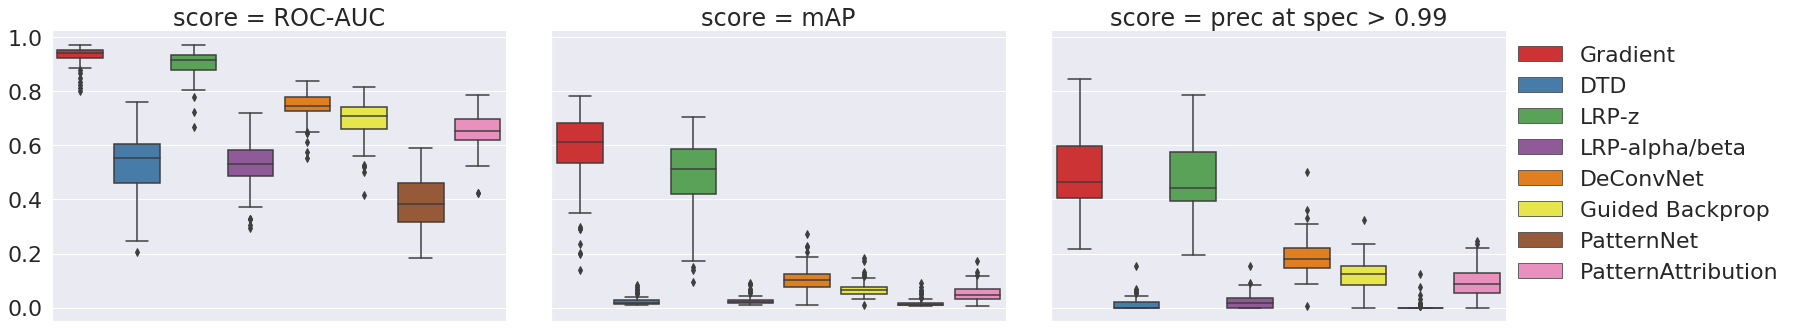

In [38]:
sns.set(font_scale=2)

g = sns.FacetGrid(df_scores, col='score', height=6, aspect = 1.2, legend_out = True)
g = g.map_dataframe(sns.boxplot, x='method', y='vals', data=df_scores,
                    orient='v', hue='method', dodge = False, palette = 'Set1')
g.fig.subplots_adjust(top=0.85, wspace = 0.1)
for ax in g.axes.flat:
    labels = ax.set_xticklabels([]) # get x labels

g.fig.subplots_adjust(bottom=0.18)
g.add_legend()

if save_fig is True: 
    if brain_pixels: 
        output_path = f'figures/only_brain_boxplot_{name}.pdf'
    else: 
        output_path = f'figures/boxplot_{name}.pdf'
    g.fig.savefig(os.path.join(result_dir, output_path), orientation='landscape', dpi=300, bbox_inches = 'tight')

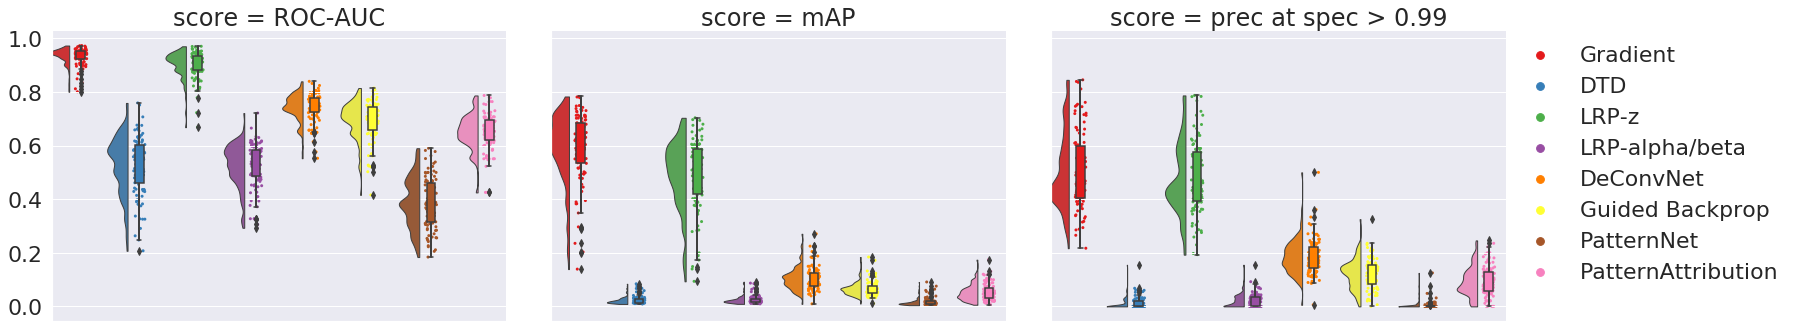

In [39]:
sns.set(font_scale=2)

g = sns.FacetGrid(df_scores, col='score', height=6, aspect = 1.2, legend_out = True)
g = g.map_dataframe(pt.RainCloud, x='method', y='vals', data=df_scores,
                    orient='v', hue='method', dodge = False, palette = 'Set1')
g.fig.subplots_adjust(top=0.85, wspace = 0.1)
for ax in g.axes.flat:
    labels = ax.set_xticklabels([]) # get x labels

g.fig.subplots_adjust(bottom=0.18)
g.add_legend()

if save_fig is True:
    if brain_pixels: 
        output_path = f'raincloud_plot_mri_medneurips.pdf'
    else: 
        output_path = f'figures/raincloud_{name}.pdf'
    g.fig.savefig(os.path.join('/ritter/share/projects/Methods/Budding_interpret_ground_truth/results/perlin_vs_mri', output_path), orientation='landscape', dpi=300, bbox_inches = 'tight')

In [40]:
quit()